In [30]:
import functools
import json
import os
import re
from collections import Counter

clean_pattern = "<.*?>|:[ 0-9.]+|[({\[\]})\r\n]"  # 清除模型词、权重词


def get_prompt_words(prompt):
    return [word.strip() for word in re.sub(clean_pattern, "", prompt).split(",")] if prompt else []


def prompt_words():
    cnt = Counter()

    def counter(prompt):
        for word in filter(lambda x: x, get_prompt_words(prompt)):
            cnt[word] += 1

        return cnt

    return counter


negative_prompt_words = prompt_words


def counter(func):
    cnt = Counter()

    @functools.wraps(func)
    def wrapped(*args, **kwargs):
        result = func(*args, **kwargs)
        if result:
            cnt[result] += 1
        return cnt
    return wrapped


@counter
def size(meta):
    return meta.get("size")


@counter
def steps(meta):
    return meta.get("steps")


@counter
def sampler(meta):
    return meta.get("sampler")


@counter
def cfg_scale(meta):
    return meta.get("cfg_scale")


model_map = {}


@counter
def model(meta):
    model_hash = meta.get("model_hash")
    if not model_hash:
        return

    _model = meta.get("model") or model_map.get(model_hash)
    if not _model:
        return

    if model_hash not in model_map and _model:
        model_map[model_hash] = _model

    return f"{_model}_{model_hash}"




In [31]:
def loads_data():
    size_cnt, steps_cnt, sampler_cnt, cfg_scale_cnt, model_cnt \
        = size({}), steps({}), sampler({}), cfg_scale({}), model({})
    prompt_words_cnt, negative_prompt_words_cnt = prompt_words(), negative_prompt_words()

    for path in os.listdir("data"):
        with open(f"data/{path}/images.txt", "r") as r:
            for line in r:
                meta = json.loads(line)["meta"]
                size(meta)
                steps(meta)
                sampler(meta)
                cfg_scale(meta)
                model(meta)

                prompt_words_counter = prompt_words_cnt(meta["prompt"])
                negative_prompt_words_counter = negative_prompt_words_cnt(meta["negative_prompt"])

    return (
        size_cnt,
        steps_cnt,
        sampler_cnt,
        cfg_scale_cnt,
        model_cnt,
        prompt_words_counter,
        negative_prompt_words_counter
    )

In [32]:
(
    size_cnt,
    steps_cnt,
    sampler_cnt,
    cfg_scale_cnt,
    model_cnt,
    prompt_words_cnt,
    negative_prompt_words_cnt
) = loads_data()

In [33]:
import matplotlib.pyplot as plt

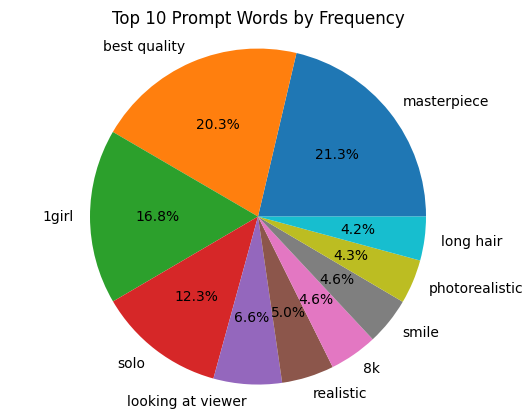

In [53]:
# 取出正向指令前10个关键词和出现次数
prompt_words = prompt_words_cnt.most_common(10)
top_prompt_words = [word[0] for word in prompt_words]
top_prompt_counts = [word[1] for word in prompt_words]

# 生成饼状图
plt.pie(top_prompt_counts, labels=top_prompt_words, autopct='%1.1f%%')
plt.title('Top 10 Prompt Words by Frequency')
plt.axis('equal')
plt.show()


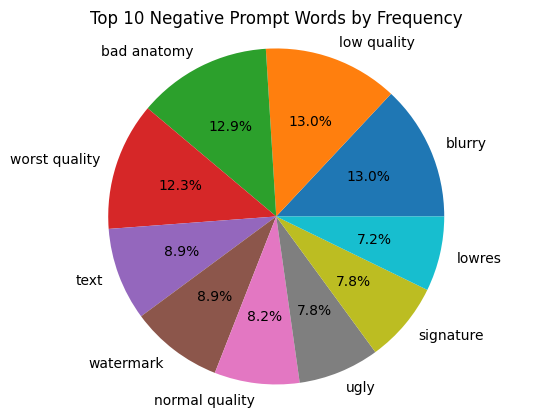

In [54]:
# 取出反向指令前10个关键词和出现次数
prompt_words = negative_prompt_words_cnt.most_common(10)
top_prompt_words = [word[0] for word in prompt_words]
top_prompt_counts = [word[1] for word in prompt_words]

# 生成饼状图
plt.pie(top_prompt_counts, labels=top_prompt_words, autopct='%1.1f%%')
plt.title('Top 10 Negative Prompt Words by Frequency')
plt.axis('equal')
plt.show()

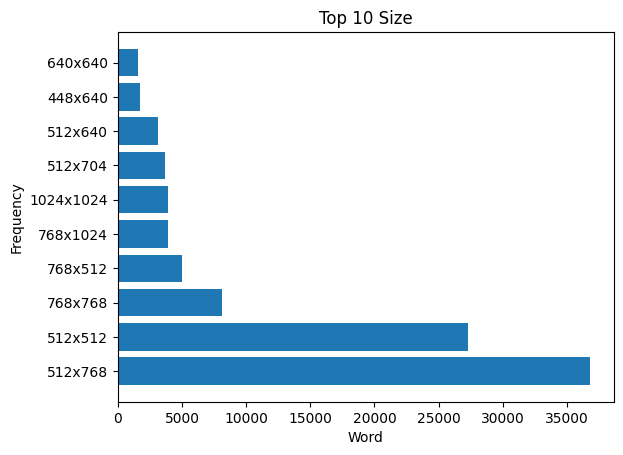

In [43]:
# 绘制Size柱状图
top_words = size_cnt.most_common(10)  # 取出现次数最多的前10个单词
x = [word[0] for word in top_words]
y = [word[1] for word in top_words]
plt.barh(x, y)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Size')
plt.show()

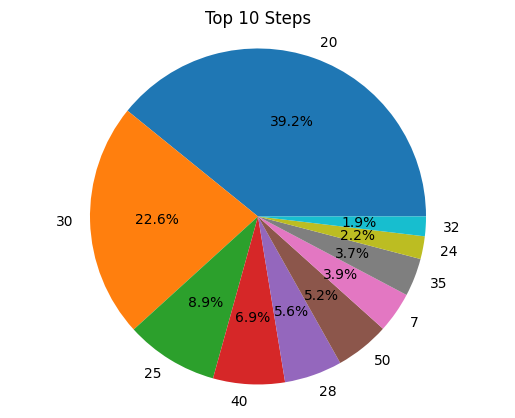

In [47]:
# 取出Steps前十
top_words = steps_cnt.most_common(10)
top_words_words = [word[0] for word in top_words]
top_words_counts = [word[1] for word in top_words]

# 生成饼状图
plt.pie(top_words_counts, labels=top_words_words, autopct='%1.1f%%')
plt.title('Top 10 Steps')
plt.axis('equal')
plt.show()

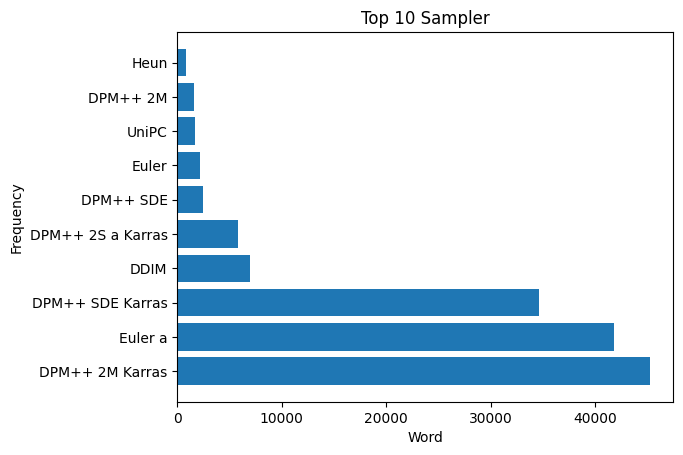

In [49]:
# 绘制Sampler柱状图
top_words = sampler_cnt.most_common(10)  # 取出现次数最多的前10个单词
x = [word[0] for word in top_words]
y = [word[1] for word in top_words]
plt.barh(x, y)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Sampler')
plt.show()

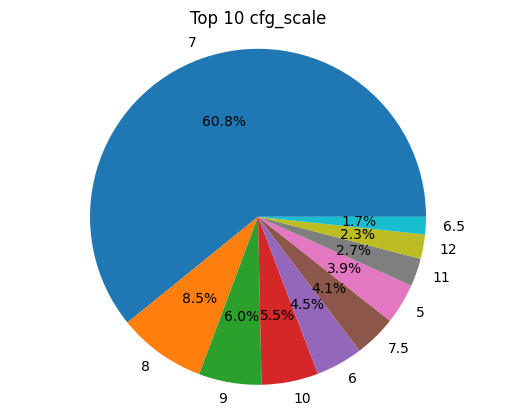

In [55]:
# 绘制cfg_scale饼状图
top_words = cfg_scale_cnt.most_common(10)
top_words_words = [word[0] for word in top_words]
top_words_counts = [word[1] for word in top_words]

plt.pie(top_words_counts, labels=top_words_words, autopct='%1.1f%%')
plt.title('Top 10 cfg_scale')
plt.axis('equal')
plt.show()

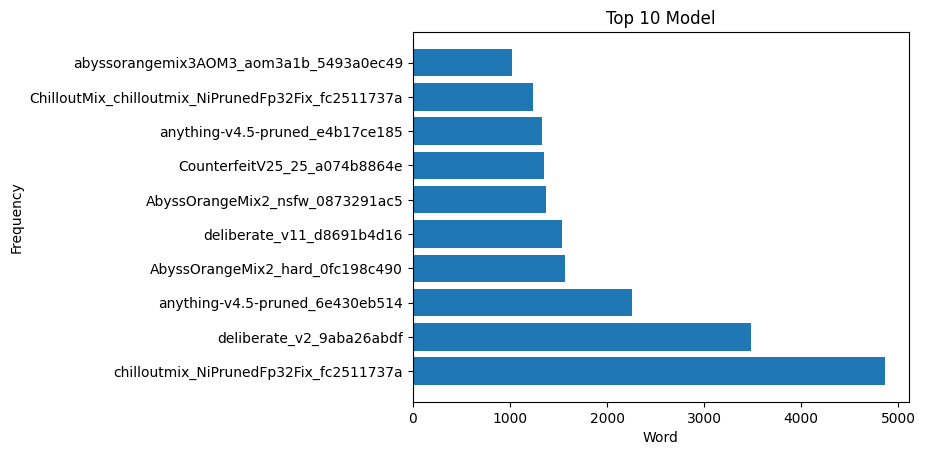

In [52]:
# 绘制Model柱状图
top_words = model_cnt.most_common(10)  # 取出现次数最多的前10个单词
x = [word[0] for word in top_words]
y = [word[1] for word in top_words]
plt.barh(x, y)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Model')
plt.show()